# 5章 1つの車両を用いた多機関の配送計画

## 5.4. 素朴な数理モデルの実装と実験

### ②データ確認

In [1]:
import pandas as pd
k_df = pd.read_csv('small_locations.csv')
print(len(k_df))
k_df.head()

5


,k,x,y,depo_flag
0,p,0,0,1
1,s1,-2,0,0
2,s2,-2,-2,0
3,s3,4,0,0
4,s4,4,2,0


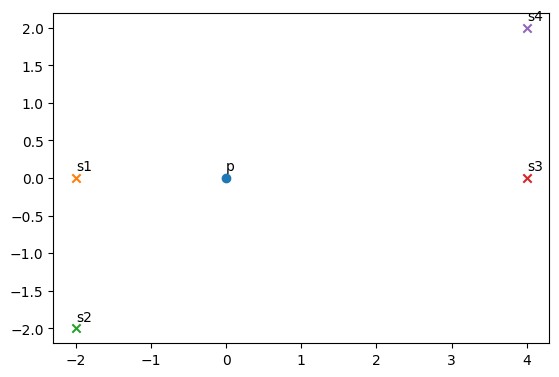

In [2]:
import matplotlib.pyplot as plt
fig = plt.subplot()
fig.set_aspect('equal')
for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker='o')
    else:
        fig.scatter(row.x, row.y, marker='x')
    fig.annotate(row.k, (row.x,row.y+0.1))
plt.show()

In [3]:
kk_df = pd.read_csv('small_distances.csv')
print(len(kk_df))
kk_df.head()

25


,k1,k2,t
0,p,p,0.000000
1,p,s1,2.000000
2,p,s2,2.828427
3,p,s3,4.000000
4,p,s4,4.472136


In [4]:
r_df = pd.read_csv('small_orders.csv')
print(len(r_df))
r_df.head()

8


,r,s,w,b,e
0,r1,s1,1000,1,1
1,r2,s2,1000,1,2
2,r3,s3,1000,2,2
3,r4,s4,1500,2,3
4,r5,s1,1500,2,4


### ③素朴な数理モデルの実装と確認（小規模データ）

In [5]:
# 配送日のリスト
D = list(range(r_df.b.min(), r_df.e.max() + 1))

# 配送センター
p = k_df[k_df.depo_flag == 1].k.tolist()[0]

# お店のリスト
S = k_df[k_df.depo_flag == 0].k.tolist()

# 地点のリスト
K = [p] + S

# 荷物のリスト
R = r_df.r.tolist()

# 各変数を定義するために必要なリスト
DKK = [(d,k1,k2) for d in D for k1 in K for k2 in K]
DR = [(d,r) for d in D for r in R]
DK = [(d,k) for d in D for k in K]

# 表示
print(D)
print(K)
print(R)
print(DKK[:5])
print(DR[:5])
print(DK[:5])

[1, 2, 3, 4]
['p', 's1', 's2', 's3', 's4']
['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8']
[(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4')]
[(1, 'r1'), (1, 'r2'), (1, 'r3'), (1, 'r4'), (1, 'r5')]
[(1, 'p'), (1, 's1'), (1, 's2'), (1, 's3'), (1, 's4')]


In [6]:
# 荷物に紐づける配送先のお店
R2S = {row.r:row.s for row in r_df.itertuples()}

# 荷物に紐づける重量
R2W = {row.r:row.w for row in r_df.itertuples()}

# 荷物に紐づける指定配送期間の開始日
R2B = {row.r:row.b for row in r_df.itertuples()}

# 荷物に紐づける指定配送期間の終了日
R2E = {row.r:row.e for row in r_df.itertuples()}

# 地点間の移動時間
KK2T = {(row.k1,row.k2):row.t for row in kk_df.itertuples()}

print('R2S:', R2S)
print('R2W:', R2W)
print('R2B:', R2B)
print('R2E:', R2E)
print('KK2T:', KK2T)

R2S: {'r1': 's1', 'r2': 's2', 'r3': 's3', 'r4': 's4', 'r5': 's1', 'r6': 's2', 'r7': 's3', 'r8': 's4'}
R2W: {'r1': 1000, 'r2': 1000, 'r3': 1000, 'r4': 1500, 'r5': 1500, 'r6': 1500, 'r7': 1500, 'r8': 3000}
R2B: {'r1': 1, 'r2': 1, 'r3': 2, 'r4': 2, 'r5': 2, 'r6': 3, 'r7': 3, 'r8': 4}
R2E: {'r1': 1, 'r2': 2, 'r3': 2, 'r4': 3, 'r5': 4, 'r6': 4, 'r7': 4, 'r8': 4}
KK2T: {('p', 'p'): 0.0, ('p', 's1'): 2.0, ('p', 's2'): 2.8284271247461903, ('p', 's3'): 4.0, ('p', 's4'): 4.47213595499958, ('s1', 'p'): 2.0, ('s1', 's1'): 0.0, ('s1', 's2'): 2.0, ('s1', 's3'): 6.0, ('s1', 's4'): 6.324555320336759, ('s2', 'p'): 2.8284271247461903, ('s2', 's1'): 2.0, ('s2', 's2'): 0.0, ('s2', 's3'): 6.324555320336759, ('s2', 's4'): 7.211102550927978, ('s3', 'p'): 4.0, ('s3', 's1'): 6.0, ('s3', 's2'): 6.324555320336759, ('s3', 's3'): 0.0, ('s3', 's4'): 2.0, ('s4', 'p'): 4.47213595499958, ('s4', 's1'): 6.324555320336759, ('s4', 's2'): 7.211102550927978, ('s4', 's3'): 2.0, ('s4', 's4'): 0.0}


### ☆「素朴な数理モデル」の実装

In [7]:
import pulp

prob = pulp.LpProblem('vrp_small', pulp.LpMinimize)

x = pulp.LpVariable.dicts('x', DKK, cat='Binary')
u = pulp.LpVariable.dicts('u', DK, cat='Integer', lowBound=0)
y = pulp.LpVariable.dicts('y', DR, cat='Binary')
h = pulp.LpVariable.dicts('h', D, cat='Continuous', lowBound=0)

for d in D:
    for k1 in K:
        # (A-1) 各配送日について、ある地点に移動する数とその地点から移動する数は一致
        prob += pulp.lpSum([x[d,k1,k2] for k2 in K]) == pulp.lpSum([x[d,k2,k1] for k2 in K])        
        
        # (A-2) 各配送日について、地点に訪問する数は高々1回まで
        prob += pulp.lpSum([x[d,k2,k1] for k2 in K]) <= 1
        
for d in D:
    # (B-1) 各配送日について、配送センターは出発地点(0番目に訪問)
    prob += u[d,p] == 0
    
    # (B-2) 各配送日における、地点への訪問順番の上下限値
    for s in S:
        prob += 1 <= u[d,s]
        prob += u[d,s] <= len(K) - 1
        
    # (B-3) 各配送日について、お店間だけのサイクルを禁止
    for s1 in S:
        for s2 in S:
            prob += u[d,s1] + 1 <= u[d,s2] + (len(K) - 1) * (1 - x[d,s1,s2])
            
# (C) 各荷物は、自社配送するなら期間内で高々1回まで
for r in R:
    prob += pulp.lpSum([y[d,r] for d in D]) <= 1
    
# (D) 各配送日について、荷物を自社配送するなら、配送先のお店に訪問
for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d,r] <= pulp.lpSum(x[d,k,tar_s] for k in K)

# (E) 各配送日について、荷物の重量は4,000[kg]以下
for d in D:
    prob += pulp.lpSum([y[d,r] * R2W[r] for r in R]) <= 4000
    
# (F) 各配送日について、ドライバーの残業時間は所定労働時間の8時間を差し引いた労働時間
for d in D:
    prob += pulp.lpSum([KK2T[k1,k2] * x[d,k1,k2] for k1 in K for k2 in K]) - 8 <= h[d]

# (G) 各配送日について、ドライバーの残業時間は3時間以内
for d in D:
    prob += h[d] <= 3
    
# (H) 各荷物は指定配送期間外の配送を禁止  
for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d,r] == 0
        if R2E[r] < d:
            prob += y[d,r] == 0

# (I) 配送費用（残業費用+外注費用）を最小化する
zangyo = pulp.lpSum([3000 * h[d] for d in D])    
gaityu = pulp.lpSum([46 * R2W[r] * (1 - pulp.lpSum(y[d,r] for d in D)) for r in R])
prob += zangyo + gaityu

# 求解（明示的にCBCソルバーを指定する）
solver = pulp.PULP_CBC_CMD()
status = prob.solve(solver)
print('ステータス:', pulp.LpStatus[status])

# 結果の表示
print('残業費用:{:.0f}[円]'.format(zangyo.value()))
print('外注費用:{:.0f}[円]'.format(gaityu.value()))
print('費用合計:{:.0f}[円]'.format(zangyo.value() + gaityu.value()))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/iwanaga/.pyenv/env/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5f/6t2pl2pd5l53yt6l2ms05lww0000gn/T/dd0e8b0135204384ab3a06f4bc2d59bb-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/5f/6t2pl2pd5l53yt6l2ms05lww0000gn/T/dd0e8b0135204384ab3a06f4bc2d59bb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 215 COLUMNS
At line 1410 RHS
At line 1621 BOUNDS
At line 1774 ENDATA
Problem MODEL has 210 rows, 156 columns and 818 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -552000 - 0.00 seconds
Cgl0002I 18 variables fixed
Cgl0003I 8 fixed, 0 tightened bounds, 50 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 25 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 7 strengthened rows, 0 substitutions

In [8]:
for d in D:
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value() == 1]
    
    time = sum([KK2T[k1,k2] for k1,k2 in X])
    print('---配送日:{}日目---'.format(d))
    print('配送重量:{}[kg]'.format(sum([y[d,r].value() * R2W[r] for r in R])))
    print('移動時間:{:.2f}[h]'.format(time))
    print('残業時間:{:.2f}[h]'.format(h[d].value()))
    print('x:', X)
    
    # 移動する地点の順番のリストを作成
    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1,k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1,k2))
                
    print('u:', [u[d,k].value() for k in Route])
    print('配送ルート:', '->'.join(Route))    

---配送日:1日目---
配送重量:2000.0[kg]
移動時間:6.83[h]
残業時間:0.00[h]
x: [('p', 's1'), ('s1', 's2'), ('s2', 'p')]
u: [0.0, 1.0, 2.0, 0.0]
配送ルート: p->s1->s2->p
---配送日:2日目---
配送重量:2500.0[kg]
移動時間:10.47[h]
残業時間:2.47[h]
x: [('p', 's3'), ('s3', 's4'), ('s4', 'p')]
u: [0.0, 1.0, 2.0, 0.0]
配送ルート: p->s3->s4->p
---配送日:3日目---
配送重量:3000.0[kg]
移動時間:6.83[h]
残業時間:0.00[h]
x: [('p', 's1'), ('s1', 's2'), ('s2', 'p')]
u: [0.0, 1.0, 4.0, 0.0]
配送ルート: p->s1->s2->p
---配送日:4日目---
配送重量:3000.0[kg]
移動時間:8.94[h]
残業時間:0.94[h]
x: [('p', 's4'), ('s4', 'p')]
u: [0.0, 1.0, 0.0]
配送ルート: p->s4->p


In [9]:
for r in R:
    # 自社トラックで配送したかどうかのフラグ
    owned_truck_flag = sum([y[d,r].value() for d in D])
    if owned_truck_flag:
        # 配送日の取得
        tar_d = [d for d in D if y[d,r].value() == 1][0]
        text = '荷物{}(お店{},{}[kg])-配送日:{}日目'.format(r, R2S[r], R2W[r], tar_d)
    else:
        # 外注費用の取得
        gc = 46 * R2W[r]
        text = '荷物{}(お店{},{}[kg])-外注費用:{}[円]'.format(r, R2S[r], R2W[r], gc)        
    print(text)

荷物r1(お店s1,1000[kg])-配送日:1日目
荷物r2(お店s2,1000[kg])-配送日:1日目
荷物r3(お店s3,1000[kg])-配送日:2日目
荷物r4(お店s4,1500[kg])-配送日:2日目
荷物r5(お店s1,1500[kg])-配送日:3日目
荷物r6(お店s2,1500[kg])-配送日:3日目
荷物r7(お店s3,1500[kg])-外注費用:69000[円]
荷物r8(お店s4,3000[kg])-配送日:4日目


### ④素朴な数理モデルの実験（中規模データ）

In [10]:
k_df = pd.read_csv('locations.csv')
print(len(k_df))
k_df.head()

10


,k,x,y,depo_flag
0,p,0.000000,0.000000,1
1,s1,0.529473,-0.397044,0
2,s2,2.916925,-0.302511,0
3,s3,0.131532,1.898977,0
4,s4,-1.091079,-0.709964,0


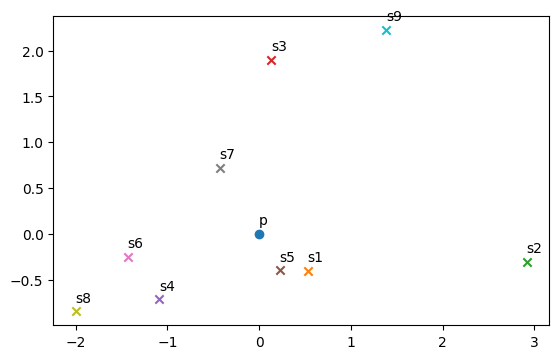

In [11]:
fig = plt.subplot()
fig.set_aspect('equal')
for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker='o')
    else:
        fig.scatter(row.x, row.y, marker='x')
    fig.annotate(row.k, (row.x,row.y+0.1))
plt.show()

In [12]:
kk_df = pd.read_csv('distances.csv')
print(len(kk_df))
kk_df.head()

100


,k1,k2,t
0,p,p,0.000000
1,p,s1,0.661805
2,p,s2,2.932570
3,p,s3,1.903527
4,p,s4,1.301730


In [13]:
r_df = pd.read_csv('orders.csv')
print(len(r_df))
r_df.head()

100


,r,s,w,b,e
0,r00,s4,1000,17,18
1,r01,s1,950,16,18
2,r02,s6,1330,2,4
3,r03,s5,1130,19,20
4,r04,s2,710,1,2


In [14]:
# 配送日のリスト
D = list(range(r_df.b.min(), r_df.e.max() + 1))

# 配送センター
p = k_df[k_df.depo_flag == 1].k.tolist()[0]

# お店のリスト
S = k_df[k_df.depo_flag == 0].k.tolist()

# 地点のリスト
K = [p] + S

# 荷物のリスト
R = r_df.r.tolist()

# 各種変数を定義するために必要なリスト
DKK = [(d,k1,k2) for d in D for k1 in K for k2 in K]
DR = [(d,r) for d in D for r in R]
DK = [(d,k) for d in D for k in K]

#表示
print(D)
print(K)
print(R[:5])
print(DKK[:5])
print(DR[:5])
print(DK[:5])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
['p', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9']
['r00', 'r01', 'r02', 'r03', 'r04']
[(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4')]
[(1, 'r00'), (1, 'r01'), (1, 'r02'), (1, 'r03'), (1, 'r04')]
[(1, 'p'), (1, 's1'), (1, 's2'), (1, 's3'), (1, 's4')]


In [15]:
# 荷物に紐づける配送先のお店
R2S = {row.r:row.s for row in r_df.itertuples()}

# 荷物に紐づける重量
R2W = {row.r:row.w for row in r_df.itertuples()}

# 荷物に紐づける指定配送期間の開始日
R2B = {row.r:row.b for row in r_df.itertuples()}

# 荷物に紐づける指定配送期間の終了日
R2E = {row.r:row.e for row in r_df.itertuples()}

# 地点の移動時間
KK2T = {(row.k1,row.k2):row.t for row in kk_df.itertuples()}

# 表示
print('R2S:', R2S)
print('R2W:', R2W)
print('R2B:', R2B)
print('R2E:', R2E)
print('KK2T:', KK2T)

R2S: {'r00': 's4', 'r01': 's1', 'r02': 's6', 'r03': 's5', 'r04': 's2', 'r05': 's5', 'r06': 's3', 'r07': 's4', 'r08': 's2', 'r09': 's6', 'r10': 's9', 'r11': 's3', 'r12': 's1', 'r13': 's7', 'r14': 's9', 'r15': 's3', 'r16': 's5', 'r17': 's7', 'r18': 's4', 'r19': 's9', 'r20': 's6', 'r21': 's8', 'r22': 's4', 'r23': 's9', 'r24': 's2', 'r25': 's3', 'r26': 's5', 'r27': 's5', 'r28': 's2', 'r29': 's4', 'r30': 's4', 'r31': 's1', 'r32': 's7', 'r33': 's8', 'r34': 's5', 'r35': 's6', 'r36': 's1', 'r37': 's7', 'r38': 's7', 'r39': 's2', 'r40': 's4', 'r41': 's3', 'r42': 's7', 'r43': 's5', 'r44': 's2', 'r45': 's9', 'r46': 's9', 'r47': 's7', 'r48': 's2', 'r49': 's9', 'r50': 's7', 'r51': 's7', 'r52': 's6', 'r53': 's9', 'r54': 's5', 'r55': 's5', 'r56': 's4', 'r57': 's8', 'r58': 's6', 'r59': 's3', 'r60': 's2', 'r61': 's7', 'r62': 's1', 'r63': 's5', 'r64': 's7', 'r65': 's8', 'r66': 's8', 'r67': 's1', 'r68': 's7', 'r69': 's2', 'r70': 's1', 'r71': 's2', 'r72': 's3', 'r73': 's3', 'r74': 's1', 'r75': 's2', 'r76':

In [16]:
import pulp

prob = pulp.LpProblem('vrp', pulp.LpMinimize)

x = pulp.LpVariable.dicts('x', DKK, cat='Binary')
u = pulp.LpVariable.dicts('u', DK, cat='Integer', lowBound=0)
y = pulp.LpVariable.dicts('y', DR, cat='Binary')
h = pulp.LpVariable.dicts('h', D, cat='Continuous', lowBound=0)

for d in D:
    for k1 in K:
        # (A-1) 各配送日について、ある地点に移動する数とその地点から移動する数は一致
        prob += pulp.lpSum([x[d,k1,k2] for k2 in K]) == pulp.lpSum([x[d,k2,k1] for k2 in K])        
        
        # (A-2) 各配送日について、地点に訪問する数は高々1回まで
        prob += pulp.lpSum([x[d,k2,k1] for k2 in K]) <= 1
        
for d in D:
    # (B-1) 各配送日について、配送センターは出発地点(0番目に訪問)
    prob += u[d,p] == 0
    
    # (B-2) 各配送日における、地点への訪問順番の上下限値
    for s in S:
        prob += 1 <= u[d,s]
        prob += u[d,s] <= len(K) - 1
        
    # (B-3) 各配送日について、お店間だけのサイクルを禁止
    for s1 in S:
        for s2 in S:
            prob += u[d,s1] + 1 <= u[d,s2] + (len(K) - 1) * (1 - x[d,s1,s2])
            
# (C) 各荷物は、自社配送するなら期間内で高々1回まで
for r in R:
    prob += pulp.lpSum([y[d,r] for d in D]) <= 1
    
# (D) 各配送日について、荷物を自社配送するなら、配送先のお店に訪問
for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d,r] <= pulp.lpSum(x[d,k,tar_s] for k in K)

# (E) 各配送日について、荷物の重量は4,000[kg]以下
for d in D:
    prob += pulp.lpSum([y[d,r] * R2W[r] for r in R]) <= 4000
    
# (F) 各配送日について、ドライバーの残業時間は所定労働時間の8時間を差し引いた労働時間
for d in D:
    prob += pulp.lpSum([KK2T[k1,k2] * x[d,k1,k2] for k1 in K for k2 in K]) - 8 <= h[d]

# (G) 各配送日について、ドライバーの残業時間は3時間以内
for d in D:
    prob += h[d] <= 3
    
# (H) 各荷物は指定配送期間外の配送を禁止  
for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d,r] == 0
        if R2E[r] < d:
            prob += y[d,r] == 0

# (I) 配送費用（残業費用+外注費用）を最小化する
zangyo = pulp.lpSum([3000 * h[d] for d in D])    
gaityu = pulp.lpSum([46 * R2W[r] * (1 - pulp.lpSum(y[d,r] for d in D)) for r in R])
prob += zangyo + gaityu

# 求解（明示的にCBCソルバーを指定する）
solver = pulp.PULP_CBC_CMD(gapRel=0.1) # 終了条件として、引数 gapRel=0.1 を指定
status = prob.solve(solver)
print('ステータス:', pulp.LpStatus[status])

# 結果の表示
print('残業費用:{:.0f}[円]'.format(zangyo.value()))
print('外注費用:{:.0f}[円]'.format(gaityu.value()))
print('費用合計:{:.0f}[円]'.format(zangyo.value() + gaityu.value()))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/iwanaga/.pyenv/env/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5f/6t2pl2pd5l53yt6l2ms05lww0000gn/T/df43b74ac9bb485e93abcf6b360d32f7-pulp.mps ratio 0.1 timeMode elapsed branch printingOptions all solution /var/folders/5f/6t2pl2pd5l53yt6l2ms05lww0000gn/T/df43b74ac9bb485e93abcf6b360d32f7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6312 COLUMNS
At line 57180 RHS
At line 63488 BOUNDS
At line 67689 ENDATA
Problem MODEL has 6307 rows, 4220 columns and 40067 elements
Coin0008I MODEL read with 0 errors
ratioGap was changed from 0 to 0.1
Option for timeMode changed from cpu to elapsed
Continuous objective value is -3.68e+06 - 0.01 seconds
Cgl0002I 1747 variables fixed
Cgl0008I 300 inequality constraints converted to equality constraints
Cgl0003I 0 fixed, 0 tightened bounds, 1442 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 t

### **===以下、実行環境によって出力が異なることに注意（終了条件を指定しているため）===**

In [17]:
for d in D:
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value()==1]
    
    time = sum([KK2T[k1,k2] for k1,k2 in X])
    print('---配送日:{}日目---'.format(d))
    print('配送重量:{}[kg]'.format(sum([y[d,r].value() * R2W[r] for r in R])))
    print('移動時間:{:.2f}[h]'.format(time))
    print('残業時間:{:.2f}[h]'.format(h[d].value()))
    
    # 移動する地点の順番のリストを作成
    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1,k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1,k2))
                
    print('配送ルート:', '->'.join(Route))    

---配送日:1日目---
配送重量:3510.0[kg]
移動時間:8.52[h]
残業時間:0.52[h]
配送ルート: p->s9->s2->p
---配送日:2日目---
配送重量:3480.0[kg]
移動時間:7.64[h]
残業時間:0.00[h]
配送ルート: p->s3->s7->s6->s8->s4->p
---配送日:3日目---
配送重量:3590.0[kg]
移動時間:8.44[h]
残業時間:0.44[h]
配送ルート: p->s7->s8->s6->s3->p
---配送日:4日目---
配送重量:3830.0[kg]
移動時間:5.78[h]
残業時間:0.00[h]
配送ルート: p->s5->s4->s8->s6->s7->p
---配送日:5日目---
配送重量:3980.0[kg]
移動時間:6.72[h]
残業時間:0.00[h]
配送ルート: p->s3->s9->s1->s5->p
---配送日:6日目---
配送重量:3880.0[kg]
移動時間:6.29[h]
残業時間:0.00[h]
配送ルート: p->s7->s5->s1->s6->s4->p
---配送日:7日目---
配送重量:3520.0[kg]
移動時間:10.76[h]
残業時間:2.76[h]
配送ルート: p->s4->s8->s5->s7->s9->p
---配送日:8日目---
配送重量:3670.0[kg]
移動時間:6.20[h]
残業時間:0.00[h]
配送ルート: p->s1->s2->s5->p
---配送日:9日目---
配送重量:3800.0[kg]
移動時間:8.75[h]
残業時間:0.75[h]
配送ルート: p->s7->s3->s2->s1->p
---配送日:10日目---
配送重量:3830.0[kg]
移動時間:8.37[h]
残業時間:0.37[h]
配送ルート: p->s5->s4->s7->s9->p
---配送日:11日目---
配送重量:3870.0[kg]
移動時間:7.40[h]
残業時間:0.00[h]
配送ルート: p->s1->s2->s7->p
---配送日:12日目---
配送重量:3690.0[kg]
移動時間:6.72[h]
残業時間:0.00[h]
配送ルート: p->s5->s1

In [18]:
for r in R:
    # 自社のトラックで配送したかどうかのフラグ
    owned_truck_flag = sum([y[d,r].value() for d in D])
    if owned_truck_flag:
        # 配送日の取得
        tar_d = [d for d in D if y[d,r].value() == 1][0]
        text = '荷物{}(お店{},{}[kg])-配送日:{}日目'.format(r, R2S[r], R2W[r], tar_d)
    else:
        # 外注費用の取得
        gc = 46 * R2W[r]
        text = '荷物{}(お店{},{}[kg])-外注費用:{}[円]'.format(r, R2S[r], R2W[r], gc)        
    print(text)

荷物r00(お店s4,1000[kg])-外注費用:46000[円]
荷物r01(お店s1,950[kg])-外注費用:43700[円]
荷物r02(お店s6,1330[kg])-配送日:2日目
荷物r03(お店s5,1130[kg])-配送日:20日目
荷物r04(お店s2,710[kg])-配送日:1日目
荷物r05(お店s5,690[kg])-配送日:10日目
荷物r06(お店s3,1180[kg])-配送日:14日目
荷物r07(お店s4,690[kg])-外注費用:31740[円]
荷物r08(お店s2,960[kg])-配送日:16日目
荷物r09(お店s6,930[kg])-配送日:14日目
荷物r10(お店s9,910[kg])-外注費用:41860[円]
荷物r11(お店s3,1100[kg])-配送日:9日目
荷物r12(お店s1,1360[kg])-配送日:12日目
荷物r13(お店s7,1120[kg])-外注費用:51520[円]
荷物r14(お店s9,820[kg])-配送日:10日目
荷物r15(お店s3,650[kg])-配送日:16日目
荷物r16(お店s5,1590[kg])-外注費用:73140[円]
荷物r17(お店s7,930[kg])-外注費用:42780[円]
荷物r18(お店s4,880[kg])-外注費用:40480[円]
荷物r19(お店s9,1470[kg])-配送日:10日目
荷物r20(お店s6,1020[kg])-配送日:4日目
荷物r21(お店s8,2020[kg])-配送日:20日目
荷物r22(お店s4,790[kg])-外注費用:36340[円]
荷物r23(お店s9,890[kg])-配送日:7日目
荷物r24(お店s2,1160[kg])-配送日:16日目
荷物r25(お店s3,560[kg])-外注費用:25760[円]
荷物r26(お店s5,1440[kg])-配送日:18日目
荷物r27(お店s5,900[kg])-配送日:7日目
荷物r28(お店s2,1230[kg])-配送日:16日目
荷物r29(お店s4,1020[kg])-配送日:4日目
荷物r30(お店s4,1020[kg])-配送日:17日目
荷物r31(お店s1,1080[kg])-配送日:8日目
荷物r32(お店s7,11

In [19]:
# 各配送日に対して、配送したお店を紐づける辞書の作成
resD2S = {d:set() for d in D}
for d,r in y:
    if y[d,r].value() == 1:
        resD2S[d].add(R2S[r])
        
for d in D:
    print('---配送日:{}日目---'.format(d))
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value() == 1]
    time = sum([KK2T[k1,k2] for k1,k2 in X])
    print('移動時間:{:.2f}[h]'.format(time))
    routeS = set([k1 for k1,k2 in X]) - set([p])
    print('(A)配送ルートのお店:', routeS)
    targetS = resD2S[d]
    print('(B)荷物の注文があるお店:', targetS)
    
    print('(A)-(B):', routeS - targetS)    

---配送日:1日目---
移動時間:8.52[h]
(A)配送ルートのお店: {'s2', 's9'}
(B)荷物の注文があるお店: {'s2', 's9'}
(A)-(B): set()
---配送日:2日目---
移動時間:7.64[h]
(A)配送ルートのお店: {'s7', 's6', 's3', 's8', 's4'}
(B)荷物の注文があるお店: {'s6', 's3', 's4'}
(A)-(B): {'s8', 's7'}
---配送日:3日目---
移動時間:8.44[h]
(A)配送ルートのお店: {'s6', 's3', 's8', 's7'}
(B)荷物の注文があるお店: {'s6', 's8', 's7'}
(A)-(B): {'s3'}
---配送日:4日目---
移動時間:5.78[h]
(A)配送ルートのお店: {'s7', 's6', 's5', 's8', 's4'}
(B)荷物の注文があるお店: {'s6', 's8', 's4'}
(A)-(B): {'s5', 's7'}
---配送日:5日目---
移動時間:6.72[h]
(A)配送ルートのお店: {'s5', 's9', 's3', 's1'}
(B)荷物の注文があるお店: {'s5', 's9', 's3', 's1'}
(A)-(B): set()
---配送日:6日目---
移動時間:6.29[h]
(A)配送ルートのお店: {'s1', 's7', 's6', 's5', 's4'}
(B)荷物の注文があるお店: {'s4', 's1', 's5', 's7'}
(A)-(B): {'s6'}
---配送日:7日目---
移動時間:10.76[h]
(A)配送ルートのお店: {'s7', 's5', 's9', 's8', 's4'}
(B)荷物の注文があるお店: {'s9', 's8', 's5', 's7'}
(A)-(B): {'s4'}
---配送日:8日目---
移動時間:6.20[h]
(A)配送ルートのお店: {'s2', 's1', 's5'}
(B)荷物の注文があるお店: {'s5', 's2', 's1'}
(A)-(B): set()
---配送日:9日目---
移動時間:8.75[h]
(A)配送ルートのお店: {'s2', 's3',

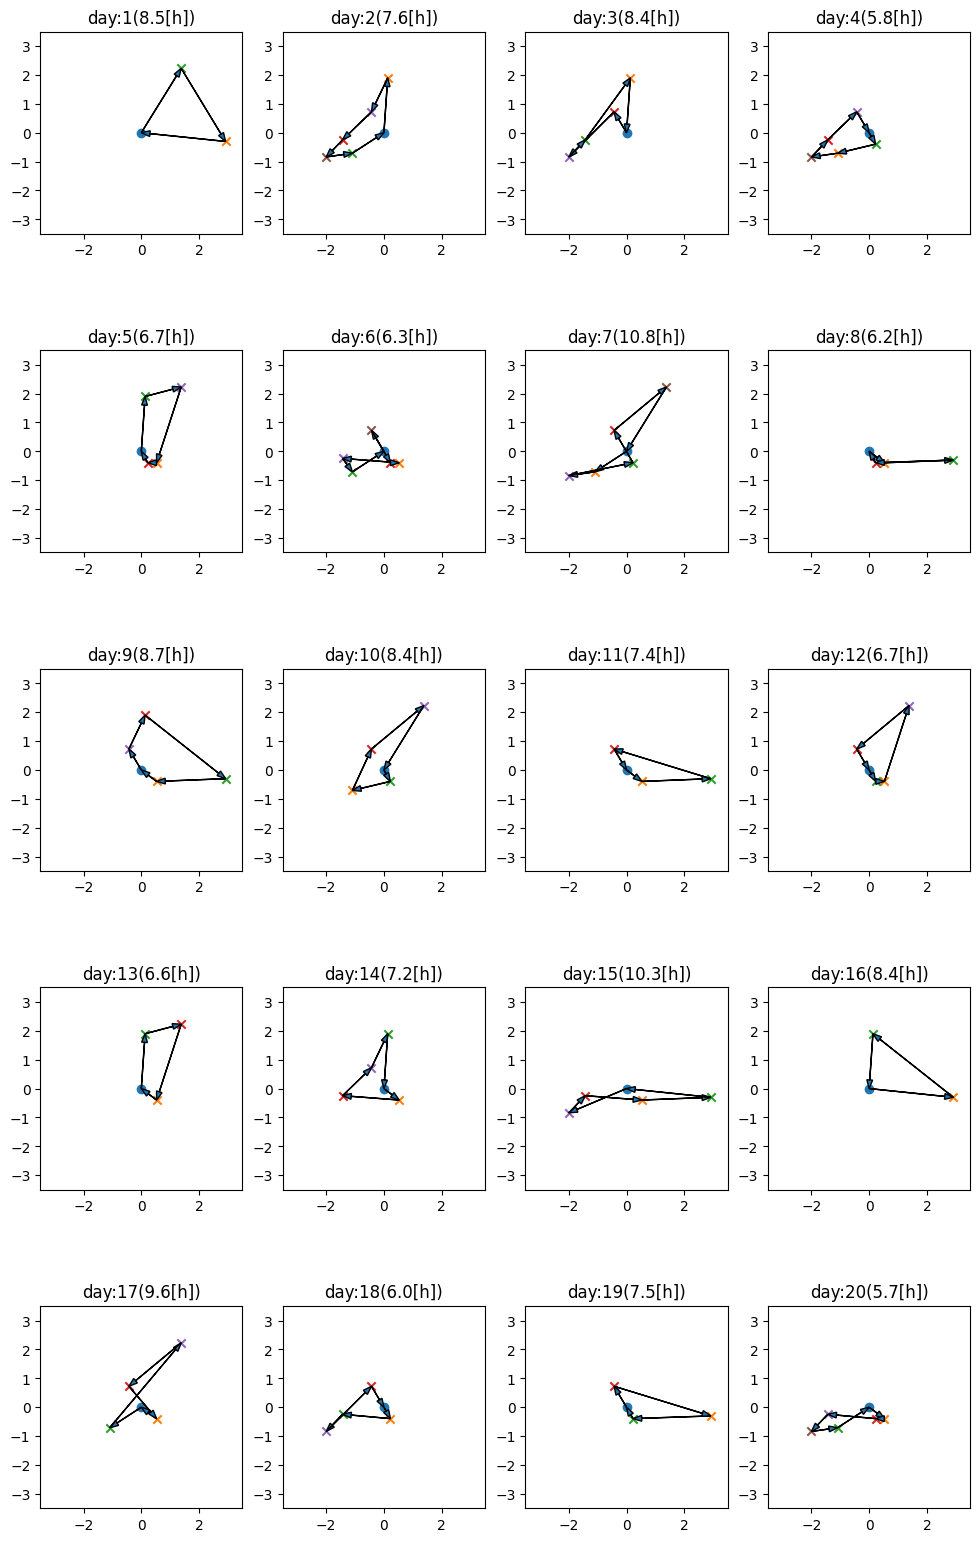

In [20]:
import matplotlib.pyplot as plt

# 各地点の座標の取得
K2XY = {row.k:(row.x,row.y) for row in k_df.itertuples()}

fig = plt.figure(figsize=(12,20))
for i in range(len(D)):
    d = D[i]
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value() == 1]
    routeK = [k1 for k1,k2 in X]
    time = sum(KK2T[k1,k2] for k1,k2 in X)
    title_text = 'day:{}({:.1f}[h])'.format(d, time)
    ax = fig.add_subplot(
            5, 4, i + 1,
            xlim=(-3.5, 3.5),
            ylim=(-3.5, 3.5),
            title=title_text)
    ax.set_aspect('equal')
    
    for row in k_df.itertuples():
        if row.k in routeK:
            if row.depo_flag:
                ax.scatter(row.x, row.y, marker='o')
            else:
                ax.scatter(row.x, row.y, marker='x')
    
    for k1,k2 in X:
        (x1,y1) = K2XY[k1]
        (x2,y2) = K2XY[k2]
        ax.arrow(x1, y1, (x2 - x1), (y2 - y1),
                head_width=0.2,
                length_includes_head=True)

## 5.5. 配送パターンを利用した数理モデリング

### ①効率的な配送パターンの列挙

### （1）ステップ１　実行可能な配送ルートの列挙

In [21]:
import pandas as pd 
k_df = pd.read_csv('locations.csv')
kk_df = pd.read_csv('distances.csv')
r_df = pd.read_csv('orders.csv')

D = list(range(r_df.b.min(), r_df.e.max() + 1))
p = k_df[k_df.depo_flag == 1].k.tolist()[0]
S = k_df[k_df.depo_flag == 0].k.tolist()
K = [p] + S
R = r_df.r.tolist()

R2S = {row.r:row.s for row in r_df.itertuples()}
R2W = {row.r:row.w for row in r_df.itertuples()}
R2B = {row.r:row.b for row in r_df.itertuples()}
R2E = {row.r:row.e for row in r_df.itertuples()}
KK2T = {(row.k1,row.k2):row.t for row in kk_df.itertuples()}

In [22]:
import pulp

def tsp(p_, S_, KK2T_):
    K = [p_] + S_
    KK = [(k1,k2) for k1 in K for k2 in K]
    prob = pulp.LpProblem('tsp', pulp.LpMinimize)
    x = pulp.LpVariable.dicts('x', KK, cat='Binary')
    u = pulp.LpVariable.dicts('u', K, cat='Integer', lowBound=0)
    
    # 各地点に必ず1回訪問する
    for k1 in K:
        prob += pulp.lpSum([x[k1,k2] for k2 in K]) == 1
        prob += pulp.lpSum([x[k2,k1] for k2 in K]) == 1
    
    # (B-1)
    prob += u[p_] == 0
    
    # (B-2)
    for s in S_:
        prob += 1 <= u[s]
        prob += u[s] <= len(K) - 1
    
    # (B-3)
    for s1 in S_:
        for s2 in S_:
            prob += u[s1] + 1 <= u[s2] + (len(K) - 1) * (1 - x[s1,s2])

    # 移動時間は11時間以内
    prob += pulp.lpSum([KK2T_[k1,k2] * x[k1,k2] for k1 in K for k2 in K]) <= 11

    # 目的関数は移動時間の最小化
    prob += pulp.lpSum([KK2T_[k1,k2] * x[k1,k2] for k1 in K for k2 in K])

    solver = pulp.PULP_CBC_CMD(msg=0)
    status = prob.solve(solver)

    if status == 1:
        X = [(k1,k2) for k1 in K for k2 in K if x[k1,k2].value() == 1]
        time = sum([KK2T_[k1,k2] for k1,k2 in X])
    else:
        X = []
        time = -1
    return status, X, time

In [23]:
testS = ['s4', 's5', 's9']
status, X, time = tsp(p, testS, KK2T)
print('ステータス:', pulp.LpStatus[status])
print('x:', X)
print('移動時間:', time)

ステータス: Optimal
x: [('p', 's4'), ('s4', 's5'), ('s5', 's9'), ('s9', 'p')]
移動時間: 8.145373915498993


In [24]:
testS = ['s1', 's2', 's3', 's4', 's5', 's9']
status, X, time = tsp(p, testS, KK2T)
print('ステータス:', pulp.LpStatus[status])
print('x:', X)
print('移動時間:', time)

ステータス: Infeasible
x: []
移動時間: -1


In [25]:
from itertools import combinations

Stp2Pat = {}
for n in range(len(S) + 1):
    # お店の集合Sからn個選ぶ組合せを列挙    
    count = 0
    for Stp in combinations(S, n): # 辞書式で列挙される
        # 配送センターpとn個のお店(Stp)の巡回セールスマン問題を解く
        status, X, time = tsp(p, list(Stp), KK2T)
        
        # 解が存在するときのみ配送ルートとして採用
        if status == 1:
            Stp2Pat[Stp] = (X, time)
            count += 1
    print('訪問するお店の数:{} 配送ルート数:{}'.format(n, count))
print('要件(ⅰ)(ⅱ)を満たす配送ルート数:', len(Stp2Pat))

訪問するお店の数:0 配送ルート数:1
訪問するお店の数:1 配送ルート数:9
訪問するお店の数:2 配送ルート数:36
訪問するお店の数:3 配送ルート数:81
訪問するお店の数:4 配送ルート数:107
訪問するお店の数:5 配送ルート数:83
訪問するお店の数:6 配送ルート数:37
訪問するお店の数:7 配送ルート数:9
訪問するお店の数:8 配送ルート数:1
訪問するお店の数:9 配送ルート数:0
要件(ⅰ)(ⅱ)を満たす配送ルート数: 364


In [26]:
for i, (Stp,Pat) in enumerate(Stp2Pat.items()):
    if i>3:break
    print('---お店の組合せ:', Stp)
    print('配送ルート:', Pat)

---お店の組合せ: ()
配送ルート: ([('p', 'p')], 0.0)
---お店の組合せ: ('s1',)
配送ルート: ([('p', 's1'), ('s1', 'p')], 1.3236097970929661)
---お店の組合せ: ('s2',)
配送ルート: ([('p', 's2'), ('s2', 'p')], 5.865139919138787)
---お店の組合せ: ('s3',)
配送ルート: ([('p', 's3'), ('s3', 'p')], 3.807054271558092)


### （2）ステップ２　効率的な配送パターンの列挙

In [27]:
# 配送日に対して配送可能な荷物のリストを紐づける辞書
D2R = {d:[] for d in D}
for r in R:
    for d in range(R2B[r], R2E[r] + 1):
        D2R[d].append(r)

# 各配送日に配送可能な荷物のリスト        
for d in D:
    print('配送日:', d, D2R[d])

配送日: 1 ['r04', 'r46', 'r53', 'r77', 'r99']
配送日: 2 ['r02', 'r04', 'r20', 'r25', 'r46', 'r47', 'r53', 'r57', 'r65', 'r77', 'r78', 'r80', 'r99']
配送日: 3 ['r02', 'r20', 'r25', 'r46', 'r47', 'r53', 'r57', 'r65', 'r77', 'r78', 'r80', 'r99']
配送日: 4 ['r02', 'r07', 'r20', 'r29', 'r47', 'r56', 'r57', 'r93', 'r96']
配送日: 5 ['r07', 'r23', 'r29', 'r56', 'r73', 'r74', 'r79', 'r93', 'r96']
配送日: 6 ['r07', 'r23', 'r27', 'r31', 'r43', 'r44', 'r54', 'r56', 'r64', 'r67', 'r73', 'r74', 'r79', 'r81']
配送日: 7 ['r23', 'r27', 'r31', 'r33', 'r43', 'r44', 'r54', 'r64', 'r66', 'r67', 'r74', 'r79', 'r81', 'r90', 'r91']
配送日: 8 ['r11', 'r27', 'r31', 'r32', 'r33', 'r44', 'r51', 'r54', 'r66', 'r67', 'r75', 'r81', 'r82', 'r90', 'r91']
配送日: 9 ['r11', 'r14', 'r19', 'r32', 'r48', 'r51', 'r66', 'r75', 'r82', 'r90', 'r91']
配送日: 10 ['r05', 'r14', 'r19', 'r22', 'r32', 'r37', 'r48', 'r51', 'r69', 'r84', 'r98']
配送日: 11 ['r05', 'r22', 'r36', 'r37', 'r48', 'r69', 'r71', 'r84', 'r98']
配送日: 12 ['r05', 'r12', 'r36', 'r37', 'r71', 'r98'

In [28]:
# 各配送日に紐づける効率的な配送パターンのリスト
D2Pat = {d:[] for d in D}
for d in D:
    # 配送日dに配送可能な荷物のリストを作成
    dayR = D2R[d]
    
    # 荷物のリストの部分集合を列挙
    for n in range(len(dayR) + 1):
        for tarR in combinations(dayR, n):
            
            # 要件(iii):荷物の重量の確認
            w = sum([R2W[r] for r in tarR])
            if w > 4000:
                continue
            
            # 荷物の配送先のお店を抽出
            tarS = set([R2S[r] for r in tarR])
            tarStp = tuple(sorted(tarS))
            
            # 要件(iv):実行可能な配送ルートとの照合
            if tarStp in Stp2Pat:
                X, time = Stp2Pat[tarStp]
                pat = (X,time,list(tarR))
                D2Pat[d].append(pat)
            else:
                continue
    print('配送日:{} 配送パターン数:{}'.format(d, len(D2Pat[d])))

配送日:1 配送パターン数:31
配送日:2 配送パターン数:614
配送日:3 配送パターン数:503
配送日:4 配送パターン数:269
配送日:5 配送パターン数:260
配送日:6 配送パターン数:1371
配送日:7 配送パターン数:1143
配送日:8 配送パターン数:1461
配送日:9 配送パターン数:332
配送日:10 配送パターン数:345
配送日:11 配送パターン数:175
配送日:12 配送パターン数:44
配送日:13 配送パターン数:93
配送日:14 配送パターン数:333
配送日:15 配送パターン数:557
配送日:16 配送パターン数:2737
配送日:17 配送パターン数:3292
配送日:18 配送パターン数:2416
配送日:19 配送パターン数:2244
配送日:20 配送パターン数:575


### ②配送パターンを利用した数理モデルの実装・実験・検証

In [29]:
# 配送日に、配送可能な配送パターンのリストを紐づける辞書
D2Q = {d:[] for d in D}

# 配送パターンに、配送可能な荷物のリストを紐づける辞書
Q2R = {}

# 配送パターンに、移動時間を紐づける辞書
Q2T = {}

# 配送パターンに、残業時間を紐づける辞書
Q2H = {}

# 配送パターンに、配送ルートを紐づける辞書
Q2X = {}

for d in D:
    for q_no, (X,time,tarR) in enumerate(D2Pat[d]):
        q = 'q_{}_{}'.format(d, q_no)
        D2Q[d].append(q)
        Q2R[q] = tarR
        Q2T[q] = time
        Q2H[q] = max(time - 8, 0)
        Q2X[q] = X
print('配送日1日目の配送パターン:', D2Q[1])        

配送日1日目の配送パターン: ['q_1_0', 'q_1_1', 'q_1_2', 'q_1_3', 'q_1_4', 'q_1_5', 'q_1_6', 'q_1_7', 'q_1_8', 'q_1_9', 'q_1_10', 'q_1_11', 'q_1_12', 'q_1_13', 'q_1_14', 'q_1_15', 'q_1_16', 'q_1_17', 'q_1_18', 'q_1_19', 'q_1_20', 'q_1_21', 'q_1_22', 'q_1_23', 'q_1_24', 'q_1_25', 'q_1_26', 'q_1_27', 'q_1_28', 'q_1_29', 'q_1_30']


In [30]:
q = 'q_1_20'
print('対象となる配送パターンの識別子:', q)
print('荷物のリスト:', Q2R[q])
print('移動時間:', Q2T[q])
print('残業時間:', Q2H[q])
print('配送ルート:', Q2X[q])

対象となる配送パターンの識別子: q_1_20
荷物のリスト: ['r04', 'r53', 'r99']
移動時間: 8.51538202654576
残業時間: 0.51538202654576
配送ルート: [('p', 's2'), ('s2', 's9'), ('s9', 'p')]


### ★「配送パターンを利用した数理モデル」の実装

In [31]:
import pulp 

prob = pulp.LpProblem('vrp_enum', pulp.LpMinimize)

x = {}
for d in D:
    for q in D2Q[d]:
        x[d,q] = pulp.LpVariable('x_{}_{}'.format(d, q), cat='Binary')
y = pulp.LpVariable.dicts('y', R, cat='Continuous', lowBound=0, upBound=1)        

# (A') 各配送日に1つの配送パターンを選択
for d in D:
    prob += pulp.lpSum([x[d,q] for q in D2Q[d]]) == 1

# (B') 各荷物は外注するか自社配送のどちらかを選択
for r in R:
    prob += y[r] + pulp.lpSum(x[d,q] for d in D for q in D2Q[d] if r in Q2R[q]) == 1

# (C') 費用合計と移動時間合計の最小化
zangyo = pulp.lpSum([3000 * Q2H[q] * x[d,q] for d in D for q in D2Q[d]])    
gaityu = pulp.lpSum([46 * R2W[r] * y[r] for r in R])
time = pulp.lpSum([x[d,q] * Q2T[q] for d in D for q in D2Q[d]])
prob += zangyo + gaityu + time

# 求解
solver = pulp.PULP_CBC_CMD(msg=1)
status = prob.solve(solver)
print('ステータス:', pulp.LpStatus[status])

# 結果の表示
print('残業費用:{:.0f}[円]'.format(zangyo.value()))    
print('外注費用:{:.0f}[円]'.format(gaityu.value()))    
print('費用剛健:{:.0f}[円]'.format(zangyo.value() + gaityu.value()))    
print('移動時間:{:.0f}[時間]'.format(time.value()))    

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/iwanaga/.pyenv/env/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5f/6t2pl2pd5l53yt6l2ms05lww0000gn/T/8dae7c7a25a94dea82c6e4fb65de2a5a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/5f/6t2pl2pd5l53yt6l2ms05lww0000gn/T/8dae7c7a25a94dea82c6e4fb65de2a5a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 125 COLUMNS
At line 140026 RHS
At line 140147 BOUNDS
At line 159043 ENDATA
Problem MODEL has 120 rows, 18895 columns and 83435 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.10697e+06 - 0.10 seconds
Cgl0004I processed model has 120 rows, 18895 columns (18895 integer (18895 of which binary)) and 83435 elements
Cbc0038I Initial state - 10 integers unsatisfied sum - 5
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 2.01881e+06 iterations 2

In [32]:
resD2Q = {d:q for d in D for q in D2Q[d] if x[d,q].value() == 1}
for d in D:
    tar_q = resD2Q[d]
    
    # 移動する地点の順番のリストを作成
    X = Q2X[tar_q].copy()
    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1,k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1,k2))
    print('---配送日:{} 配送パターン:{}---'.format(d, tar_q))
    print('移動時間:{:.2f}[時間]'.format(Q2T[tar_q]))
    print('残業時間:{:.2f}[時間]'.format(Q2H[tar_q]))
    print('配送ルート:', '->'.join(Route))
    for r in Q2R[tar_q]:
        print('荷物{}-お店{}'.format(r, R2S[r]))    

---配送日:1 配送パターン:q_1_30---
移動時間:5.82[時間]
残業時間:0.00[時間]
配送ルート: p->s3->s9->p
荷物r46-お店s9
荷物r53-お店s9
荷物r77-お店s3
荷物r99-お店s9
---配送日:2 配送パターン:q_2_358---
移動時間:9.28[時間]
残業時間:1.28[時間]
配送ルート: p->s2->s7->s6->p
荷物r02-お店s6
荷物r04-お店s2
荷物r20-お店s6
荷物r47-お店s7
---配送日:3 配送パターン:q_3_290---
移動時間:4.49[時間]
残業時間:0.00[時間]
配送ルート: p->s6->s8->s4->p
荷物r65-お店s8
荷物r78-お店s4
荷物r80-お店s6
---配送日:4 配送パターン:q_4_255---
移動時間:4.49[時間]
残業時間:0.00[時間]
配送ルート: p->s6->s8->s4->p
荷物r07-お店s4
荷物r29-お店s4
荷物r56-お店s4
荷物r57-お店s8
荷物r93-お店s6
---配送日:5 配送パターン:q_5_240---
移動時間:6.72[時間]
残業時間:0.00[時間]
配送ルート: p->s5->s1->s9->s3->p
荷物r73-お店s3
荷物r74-お店s1
荷物r79-お店s9
荷物r96-お店s5
---配送日:6 配送パターン:q_6_729---
移動時間:6.14[時間]
残業時間:0.00[時間]
配送ルート: p->s9->s1->s5->p
荷物r23-お店s9
荷物r27-お店s5
荷物r31-お店s1
荷物r67-お店s1
---配送日:7 配送パターン:q_7_346---
移動時間:5.78[時間]
残業時間:0.00[時間]
配送ルート: p->s5->s8->s7->p
荷物r33-お店s8
荷物r43-お店s5
荷物r64-お店s7
---配送日:8 配送パターン:q_8_1445---
移動時間:7.49[時間]
残業時間:0.00[時間]
配送ルート: p->s5->s2->s7->p
荷物r44-お店s2
荷物r54-お店s5
荷物r75-お店s2
荷物r81-お店s7
荷物r90-お店s7
---配送日:9 配送パターン:

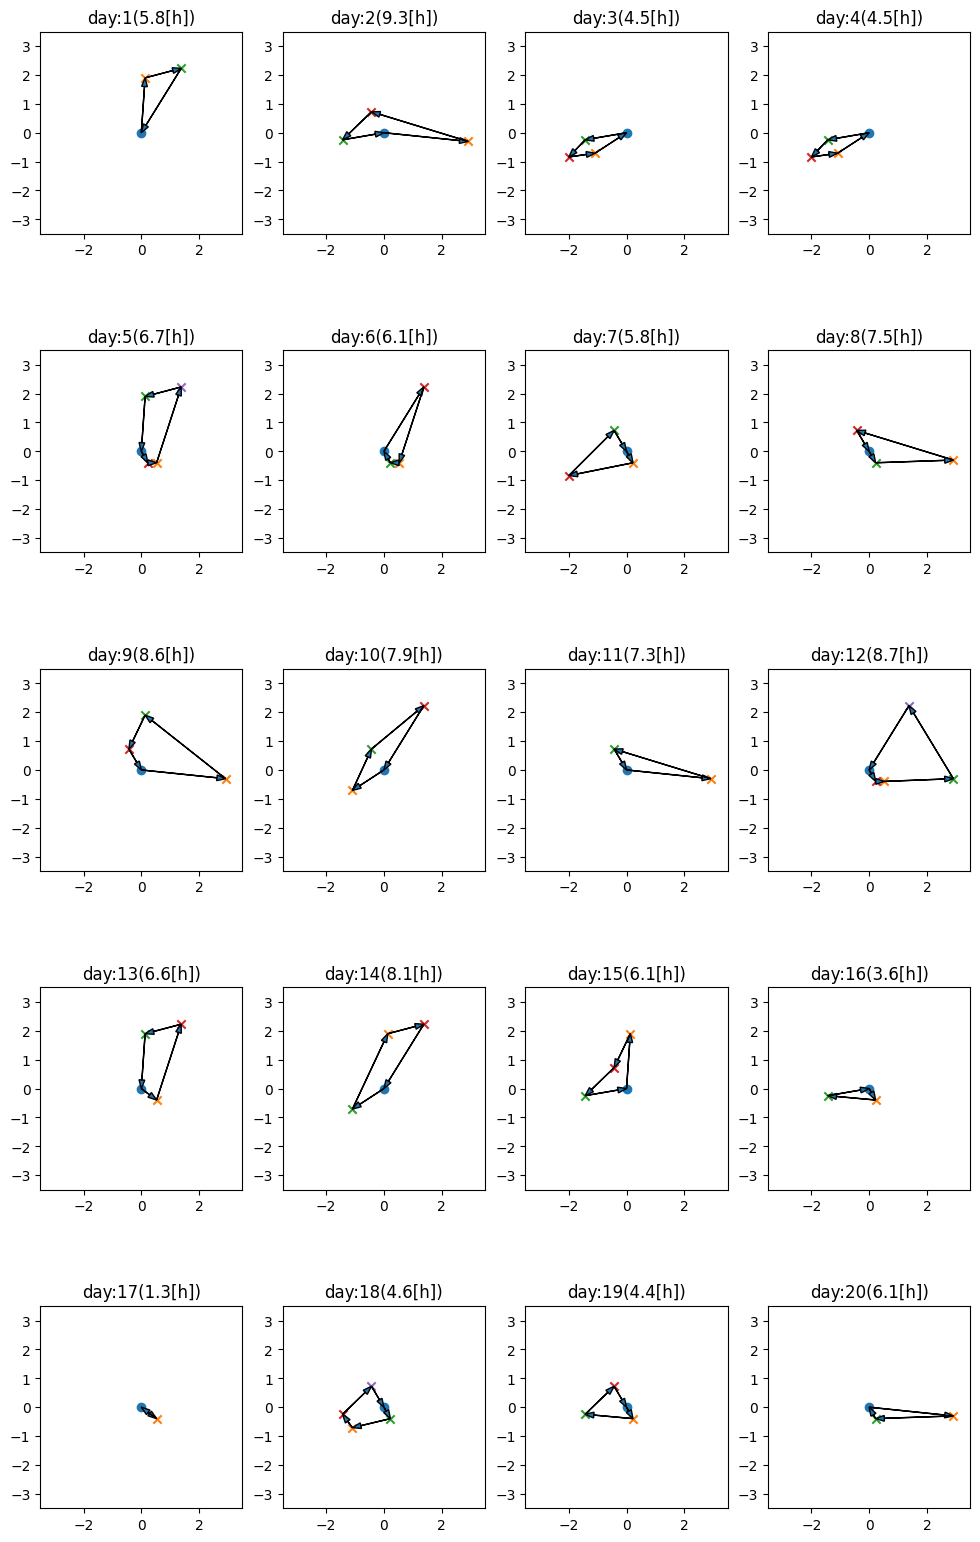

In [33]:
import matplotlib.pyplot as plt

# 各地点の座標の取得
K2XY = {row.k:(row.x,row.y) for row in k_df.itertuples()}

fig = plt.figure(figsize=(12,20))
for i in range(len(D)):
    d = D[i]
    tar_q = resD2Q[d]
    X = Q2X[tar_q]
    routeK = [k1 for k1,k2 in X]
    time = Q2T[tar_q]    
    title_text = 'day:{}({:.1f}[h])'.format(d, time)
    
    ax = fig.add_subplot(5, 4, i + 1,
                         xlim=(-3.5, 3.5),
                         ylim=(-3.5, 3.5),
                         title=title_text)
    ax.set_aspect('equal')    
    
    for row in k_df.itertuples():
        if row.k in routeK:
            if row.depo_flag:
                ax.scatter(row.x, row.y, marker='o')
            else:
                ax.scatter(row.x, row.y, marker='x')
    
    for k1,k2 in X:
        (x1,y1) = K2XY[k1]
        (x2,y2) = K2XY[k2]
        ax.arrow(x1, y1, (x2 - x1), (y2 - y1),
                head_width=0.2,
                length_includes_head=True)